# Restoring Color to Greyscale Images

In [204]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [210]:
imdir = "images/raw"
handles = [os.path.join(imdir, h) for h in os.listdir(imdir)]
random.shuffle(handles)
print "Found {l} image handles".format(l=len(handles))

Found 30113 image handles


In [233]:
import convnet
reload(convnet)
reload(image)

<module 'image' from 'image.pyc'>

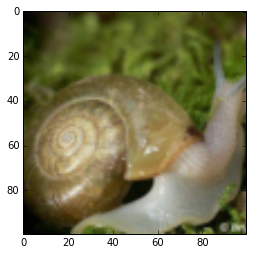

In [226]:
val_images, test_images, train_handles = convnet.ValidationTestTrainSplit(
    handles, 50, 10, 100, 100)
plt.imshow(val_images[0])
plt.show()

In [221]:
net, train_fn, val_fn = convnet.CreateTheanoExprs(100, 100, 0.001)

In [235]:
batch_stats, val_stats, err, net = convnet.Train(
    num_batches=6,
    validate_every_n_batches=2,
    height=100,
    width=100,
    batch_size=20,
    image_handles=handles,
    val_set_size=100,
    test_set_size=100,
    net=net,
    train_fn=train_fn,
    val_fn=val_fn)

Loading validation and testing images...
Starting training...
Training batch 0 of 20 images. Last time = 0.00 seconds. Last load time = 0.00 seconds. Last error = 1.00000.
Memread in 2.50317406654
Reshape in 8.70227813721e-05
Training batch 1 of 20 images. Last time = 0.53 seconds. Last load time = 0.40 seconds. Last error = 1.05912.
Memread in 2.47007489204
Reshape in 0.000891923904419

Validating...
Validated on 100 images in 1.06 seconds. Error = 1.07718.

Training batch 2 of 20 images. Last time = 0.53 seconds. Last load time = 0.37 seconds. Last error = 1.05891.
Memread in 2.49958300591
Reshape in 8.60691070557e-05
Training batch 3 of 20 images. Last time = 0.52 seconds. Last load time = 0.38 seconds. Last error = 1.05867.
Memread in 2.47851610184
Reshape in 7.70092010498e-05

Validating...
Validated on 100 images in 1.06 seconds. Error = 1.07698.

Training batch 4 of 20 images. Last time = 0.54 seconds. Last load time = 0.37 seconds. Last error = 1.05840.
Memread in 2.47870492935

In [216]:
batch_stats

[(0, array(3.7757403883615015), 0.9852039813995361, 0.2909209728240967),
 (1, array(2.775615947065782), 1.0064749717712402, 0.27067995071411133),
 (2, array(2.1048962687251165), 1.0181078910827637, 0.3019270896911621),
 (3, array(2.50732222401235), 0.9946908950805664, 0.26685595512390137),
 (4, array(2.202476807069962), 0.9913790225982666, 0.29868197441101074),
 (5, array(2.2000035501358117), 1.0145068168640137, 0.26184701919555664)]

In [ ]:
def PrintShapes(net):
    print net.__class__.__name__, getattr(net, "input_shape", ""), "=>", getattr(net, "output_shape", "")
    input_layer = getattr(net, "input_layer", None)
    if input_layer:
        PrintShapes(input_layer)

In [ ]:
PrintShapes(net)